## 判斷是否使用Google colab執行
若是，則從Google Drive掛載資料，Google colab專用 否則應設定 ROOT_DIR

In [1]:
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

print('IN_COLAB', IN_COLAB)

if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)
    ROOT_DIR = '/content/drive/Shared drives/Straight A students/類神經網路/flowers'
else:
    ROOT_DIR = 'flowers'

IN_COLAB True
Mounted at /content/drive


In [0]:
import torch

torch.manual_seed(1)
n_epoch = 10
batch_size = 128
learning_rate = 0.0002

## imports

In [0]:
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

## VGG

In [0]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

In [0]:
class VGG(torch.nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1000),
        )
    
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [torch.nn.MaxPool2d(kernel_size = 2, stride = 2)]
            else:
                layers += [torch.nn.Conv2d(in_channels, x, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(x), torch.nn.ReLU(inplace = True)]
                in_channels = x
        layers += [torch.nn.AvgPool2d(kernel_size = 1, stride = 1)]
        return torch.nn.Sequential(*layers)

## Load data

In [6]:
flowers_dataset = torchvision.datasets.ImageFolder(
    ROOT_DIR,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor()
    ])
)
print(flowers_dataset)
train_loader = DataLoader(dataset = flowers_dataset, batch_size = batch_size, shuffle = True)

Dataset ImageFolder
    Number of datapoints: 4323
    Root location: /content/drive/Shared drives/Straight A students/類神經網路/flowers
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               ToTensor()
           )


## 主程式

In [7]:
model = VGG('VGG11').cuda()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [8]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = learning_rate)

for I in range(n_epoch):
    J = 0
    for image, label in train_loader:
        J += 1
        image = Variable(image).cuda()
        label = Variable(label).cuda()
        # print(image.shape, label.shape)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()

        print('epoch [{}-{}/{}], loss:{:.4f}'.format(I + 1, J, n_epoch, loss.data.item()))

epoch [1-1/10], loss:6.8473
epoch [1-2/10], loss:3.3467
epoch [1-3/10], loss:9.3071
epoch [1-4/10], loss:17.1866
epoch [1-5/10], loss:16.7213
epoch [1-6/10], loss:8.5592
epoch [1-7/10], loss:5.1483
epoch [1-8/10], loss:3.9466
epoch [1-9/10], loss:2.8326
epoch [1-10/10], loss:3.2036
epoch [1-11/10], loss:2.9449
epoch [1-12/10], loss:2.5684
epoch [1-13/10], loss:2.2563
epoch [1-14/10], loss:2.1720
epoch [1-15/10], loss:1.7110
epoch [1-16/10], loss:1.7842
epoch [1-17/10], loss:1.7623
epoch [1-18/10], loss:1.8058
epoch [1-19/10], loss:1.5819
epoch [1-20/10], loss:1.6182
epoch [1-21/10], loss:1.6044
epoch [1-22/10], loss:1.5119
epoch [1-23/10], loss:1.5716
epoch [1-24/10], loss:1.4478
epoch [1-25/10], loss:1.4867
epoch [1-26/10], loss:1.3943
epoch [1-27/10], loss:1.3392
epoch [1-28/10], loss:1.4311
epoch [1-29/10], loss:1.4573
epoch [1-30/10], loss:1.3046
epoch [1-31/10], loss:1.4579
epoch [1-32/10], loss:1.3417
epoch [1-33/10], loss:1.2997
epoch [1-34/10], loss:1.3421
epoch [2-1/10], loss:

## 測試

GroundTruth:  dandelion  rose daisy daisy


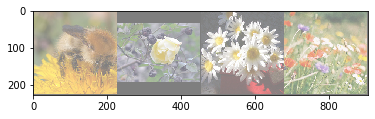

In [9]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % flowers_dataset.classes[labels[j]] for j in range(4)))

In [10]:
image = image.cuda()
label = label.cuda()
output = model(image)

_, predicted = torch.max(output, 1)

print('Predicted: ', ' '.join('%5s' % flowers_dataset.classes[predicted[j]]
                              for j in range(4)))

Predicted:  tulip  rose tulip daisy


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network: %d %%' % (100 * correct / total))

Accuracy of the network: 92 %
